# Importing packages 

In [1]:
import sys
sys.path.append('../../src/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import copy
from scipy import sparse
import scipy.stats
import random
from fitter import Fitter
import attr
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
import pylogit as pl
import viz
from sklearn.linear_model import LogisticRegression
import json

# 1. Define functions to be used in notebook

In [3]:
def DistNodeNoParent(data_long,
                     alt_id_col,
                     obs_id_col,
                     alt_spec_dic,
                     alt_name_dic,
                     ind_spec,
                     trip_spec,
                     var_types,
                     cont_dists=None):
    """
    Function to find the distribution of specific variables
    from a long format dataset.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.
        
    alt_id_col: string
        Name of the column with alternative ids.
        
    obs_id_col: string
        Name of the column with observation ids.
        
    alt_spec_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a list of strings representing the name of
        variables without parents per alternative.
        
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    ind_spec: list
        List containing strings of the names of 
        individual specific variables.
        
    trip_spec: list
        List containing string of the names of 
        trip specific variables.
        
    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').
        
    cont_dists: list
        List of continuous RVs distribution names from scipy.
        
    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """
    
    params_dict = {}

    # Code for Individual Specific Variables
    for ind in ind_spec:
        # generate array of values for individual specific variable
        ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
        # Get distribution if variable is categorical
        if var_types[ind] in ['categorical', 'numerical']:
            # If only one category
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(ind,{})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(ind_var.max()+1)
                array_bincount = np.bincount(ind_var)
                probs = array_bincount / len(ind_var)
                params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            # If not categorical but not one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=ind_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    for alt in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        mode_data = data_long.loc[data_long[alt_id_col] == alt]
        # Loop around the alternative specific variables in the input dictionary
        for var in alt_spec_dic[alt]:
            # If data is to be taken as empirical values
            if var_types[var] == 'empirical':
                # If only one value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
            # If data is categorical
            elif var_types[var] == 'categorical':
                # If only one category
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    # If more than one category, compute the frequency of values
                    # and store as parameters
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
                    np_array_range = np.arange(mode_data[var].max()+1)
                    array_bincount = np.bincount(mode_data[var])
                    probs = array_bincount / len(mode_data[var])
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
                                                                            probs]
            else:
                # If data is not categorical but has one unique value
                if len(mode_data[var].unique()) == 1:
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                # If data is not categorical but has more than one unique value
                else:
                    # Use the Fitter library to fit distributions
                    # to the data
                    fitter_object = Fitter(data=mode_data[var],
                                           distributions=cont_dists,
                                           timeout=30)
                    fitter_object.fit()
                    # Get the best distribution and store in dictionary
                    BestDict = fitter_object.get_best()
                    # Add name of alternative to variable and store distriburion & parameters
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    for var in trip_spec:
        # generate array of values for trip specific variable
        trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        # If data is to be taken as empirical values
        if var_types[var] == 'empirical':
            # If data has one unique value
            if trip_var.unique() == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
            # If data has more than one unique value
            else:
                params_dict.setdefault(var, {})['distribution'] = 'empirical'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
        # Get distribution if variable is categorical
        elif var_types[var] == 'categorical':
            # If only one category
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If more than one category
            else:
                params_dict.setdefault(var, {})['distribution'] = 'categorical'
                # Count frequency of values and store it as paramater of distribution
                np_array_range = np.arange(trip_var.max()+1)
                array_bincount = np.bincount(trip_var)
                probs = array_bincount / len(trip_var)
                params_dict.setdefault(var, {})['parameters'] = [np_array_range,
                                                  probs]
        else:
            # If not categorical but just one unique value
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            # If not categorical but just one unique value
            else:
                # Use the Fitter library to fit distributions
                # to the data
                fitter_object = Fitter(data=trip_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                # Get the best distribution and store in dictionary
                BestDict = fitter_object.get_best()
                params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

    return params_dict


def SimNodeNoParent(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.
    
    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.
        
    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.
    
    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    """
    # Create Empty DataFrame with keys from params_dict
    Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
    Sim_Df = Sim_Df.fillna(0)
    
    # Loop around each of the variables in params_dict
    # and simulate data for them
    for column in list(params_dict.keys()):
        # Simulate data for categorical variables
        if params_dict[column]['distribution'] == 'categorical':
            value = params_dict[column]['parameters'][0]
            freq = params_dict[column]['parameters'][1]
            data_sim = np.random.choice(a=value,
                                        p=freq,
                                        size=size)
            Sim_Df[column] = data_sim
        
        # Simulate variables for data with a single unique value
        elif params_dict[column]['distribution'] == 'constant':
            data_sim = params_dict[column]['parameters'][0]
            Sim_Df[column] = data_sim
        
        # Simulate data using values from array, sampling
        # with replacement
        elif params_dict[column]['distribution'] == 'empirical':
            data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
            Sim_Df[column] = data_sim
        
        # Simulate data for continuous variables
        else:
            # Get scipy distribution from its
            # name in the params dictionary
            dist = getattr(scipy.stats,
                           params_dict[column]['distribution'])
            data_sim = dist.rvs(*params_dict[column]['parameters'],
                                size=size)
            Sim_Df[column] = data_sim
        
    return Sim_Df


def FitAlternativeRegression(regressions, reg_types, data):
    
    """
    Function to store regression models based on causal graph
    in a dictionary.
    
    Parameters
    ----------
    regressions: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Values of the dictionary
        are tuples/lists with the first item is a string
        of the name of the independent variable and the
        second item is a string of the name of the 
        dependent variable.
    
    reg_types: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Keys should be similar to the
        keys from the `regressions` dictionary. Values are
        strings representing the type of regressions to be
        ran.
        
    Returns
    -------
    Dictionary with keys as the regression name and values
    as regression models stores. Methods from these fitted
    models can be accessed through the values of the dictionary.
    """
    
    # Initiate the regressions results dictionary
    regression_results = {}
    
    # Loop around the regressions
    for reg in regressions.keys():
        # If linear regression
        if reg_types[reg] == 'linear':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.OLS(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
        # Binary logistic regression
        if reg_types[reg] == 'binary_logistic':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.Logit(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results

        # Multinomial logistic regression
        if reg_types[reg] == 'multinomial_logistic':
            # Prepare data and initialize model
            # regressions[reg][0] COULD be a list
            # Check the length, and reshape if
            # array is 1d.
            if len(data[regressions[reg][0]].shape) == 1:
                data_x = data[regressions[reg][0]].values.reshape((-1,1))
            else:
                data_x = data[regressions[reg][0]]
            
            data_y = data[regressions[reg][1]]
            mnl_reg = LogisticRegression(multi_class='multinomial', solver='newton-cg')

            # Fit model
            model = mnl_reg.fit(data_x, data_y)
            
            # Store model - TODO: come up with a better representation
            # of the regression name in the dictionary.
            if len(regressions[reg][1]) == 1:
                regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = model
            else:
                regression_results[json.dumps(regressions[reg][1])+'_on_'+regressions[reg][0]] = model
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results


def SimulateAvailability(data_long, sim_data, obs_id_col, alt_name_dict):
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.
    
    sim_data: Pandas DataFrame
        Wide format dataframe resulting from SimDf
    
    obs_id_col: string
        Name of the column in data_long with 
        observation ids.
    
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.
    
    """
    
    # Create empty Series to hold number of available alternatives
    series = pd.Series([])
    
    # Loop around each observation to record the
    # available number of alternatives for each observation
    for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
        series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_data.shape[0]
    alts_sim = np.random.choice(a=np.arange(series.max()+1),
                                p=np.bincount(series)/len(series),
                                size=av_size)

    # Simulate the availability matrix based on number 
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]
    
    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)
    
    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(av_sim, columns=AV_columns)
    
    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data
    fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
    fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    
    # Concatenate the simulated data with availability data and fake choice data
    # and return Sim_DF_AV
    Sim_DF_AV = pd.concat([sim_data, AV_Df, fake_choice_df], axis=1, sort=False)
    return Sim_DF_AV

def PlotParams(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.
    
    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.
        
    model: Pylogit model.
        Estimated data generating model to compare 
        estimated parameters based on simulated data
        to.
        
    size: tuple
        Figure size
        
    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)
    
    # Initialize the figure size
    plt.figure(figsize=fig_size)
    
    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')
    
    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name], color='black', ls='--',label='Data Generating Parameter')
    
    # Add a title for the figure
    plt.title(label='Histogram of '+'"'+sim_par.name+'"', fontdict={'fontsize':16})
    
    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)
    
    # Add a legend
    plt.legend()

# 2. MNL Model Estimation using Bike Data

## 2.1. Data Ingestion and Exploration

In [4]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [5]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [6]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. MNL Model Specification 

In [7]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

## 2.3. Model Estimation

In [8]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Wed, 15 Apr 2020   Pseudo R-squ.:                   0.332
Time:                             11:23:17   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# 3. Framework for Simulation from Causal Graph

## 3.1. Causal Models for each Utility Function 

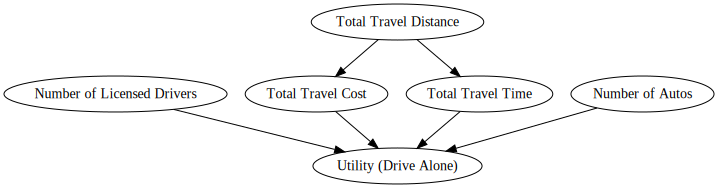

In [9]:
# Define the causal model
V_Drive_Alone = CausalGraphicalModel(nodes=["Total Travel Distance",
                                            "Total Travel Time",
                                            "Total Travel Cost",
                                            "Number of Autos",
                                            "Number of Licensed Drivers",
                                            "Utility (Drive Alone)"],
                                     edges=[("Total Travel Distance","Total Travel Time"),
                                            ("Total Travel Distance","Total Travel Cost"),
                                            ("Total Travel Time", "Utility (Drive Alone)"), 
                                            ("Total Travel Cost", "Utility (Drive Alone)"), 
                                            ("Number of Autos", "Utility (Drive Alone)"),
                                            ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

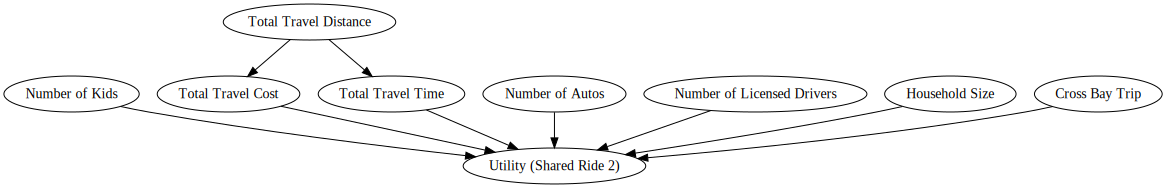

In [10]:
# Define the causal model
V_Shared_2 = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 2)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 2)"),
                                         ("Number of Autos", "Utility (Shared Ride 2)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 2)"),
                                         ("Household Size", "Utility (Shared Ride 2)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                                         ("Number of Kids", "Utility (Shared Ride 2)")
    ]
)

# draw the causal model
V_Shared_2.draw()

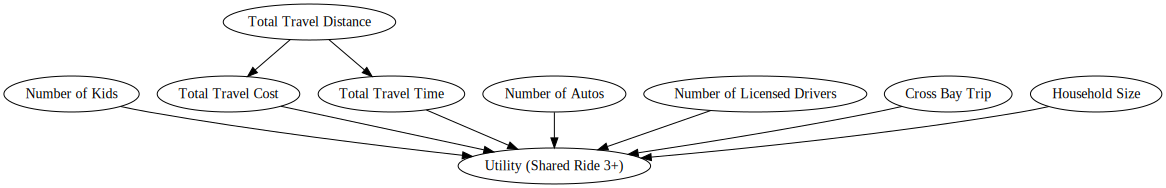

In [15]:
# Define the causal model
V_Shared_3p = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 3+)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 3+)"),
                                         ("Number of Autos", "Utility (Shared Ride 3+)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                                         ("Household Size", "Utility (Shared Ride 3+)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                                         ("Number of Kids", "Utility (Shared Ride 3+)")
    ]
)

# draw the causal model
V_Shared_3p.draw()

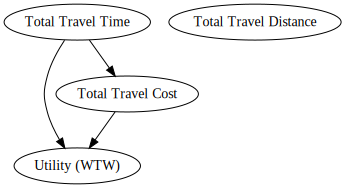

In [16]:
# Define the causal model
V_WTW = CausalGraphicalModel(nodes=["Total Travel Distance",
                                    "Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTW)"),
                                         ("Total Travel Cost", "Utility (WTW)")
    ]
)

# draw the causal model
V_WTW.draw()

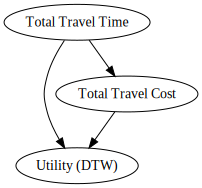

In [17]:
# Define the causal model
V_DTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Cost",
                                         "Utility (DTW)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (DTW)"),
                                         ("Total Travel Cost", "Utility (DTW)")
    ]
)

# draw the causal model
V_DTW.draw()

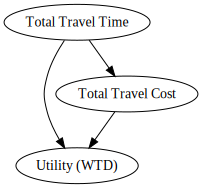

In [18]:
# Define the causal model
V_WTD = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTD)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (WTD)"),
                                    ("Total Travel Cost", "Utility (WTD)")
    ]
)

# draw the causal model
V_WTD.draw()

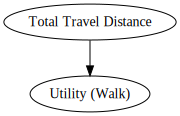

In [19]:
# Define the causal model
V_Walk = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Walk)"],
                              edges=[("Total Travel Distance", "Utility (Walk)")
    ]
)

# draw the causal model
V_Walk.draw()

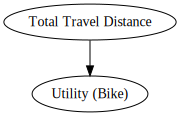

In [20]:
# Define the causal model
V_Bike = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Bike)"],
                              edges=[("Total Travel Distance", "Utility (Bike)")
    ]
)

# draw the causal model
V_Bike.draw()

## 3.2. Distribution of Nodes without parents

### 3.2.1. Set up all needed variables

In [21]:
# Observation id column
observation_id_col = 'observation_id'

# Alternative id column
alternative_id_col = 'mode_id'

# Individual specific variables list
individual_specific_variables = ['household_size','num_kids',
                                'num_cars','num_licensed_drivers']

# Alternative specific variables dictionary
alternative_specific_dict = {1:['total_travel_distance'],
                             2:['total_travel_distance'],
                             3:['total_travel_distance'],
                             4:['total_travel_time'],
                             5:['total_travel_time'],
                             6:['total_travel_time'],
                             7:['total_travel_distance'],
                             8:['total_travel_distance']}

# Trip specific variables list
trip_specific_variables = ['cross_bay']

# Alternative name dictionary
alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

# Variable type Dictionary
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

### 3.2.2. Find Distributions of nodes without parents 

In [22]:
bike_data_params = DistNodeNoParent(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec_dic=alternative_specific_dict,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)

In [23]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'gamma',
  'pa

## 3.3. Regressions for each causal graph 

### 3.3.1. Drive Alone 

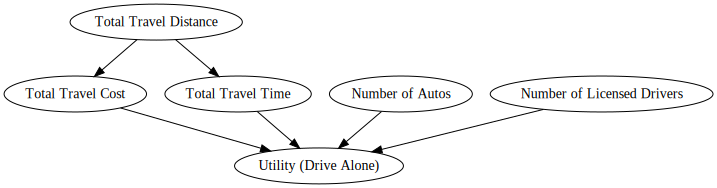

In [24]:
V_Drive_Alone.draw()

In [25]:
Drive_Alone_Df = bike_data_long[bike_data_long['mode_id']==1]
Drive_Alone_Df.reset_index(drop=True,inplace=True)
Drive_Alone_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Drive_Alone_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.2. Shared-2

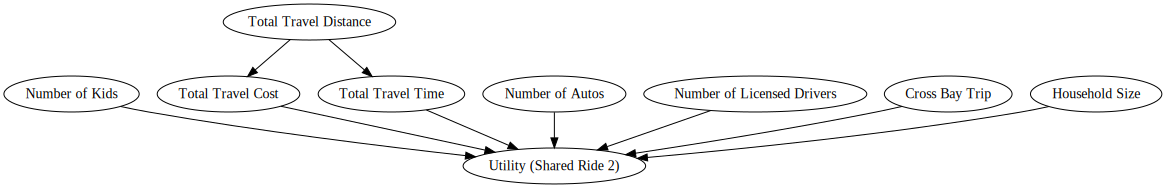

In [26]:
V_Shared_2.draw()

In [27]:
Shared_2_Df = bike_data_long[bike_data_long['mode_id']==2]
Shared_2_Df.reset_index(drop=True,inplace=True)
Shared_2_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_2_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.3. Shared-3+

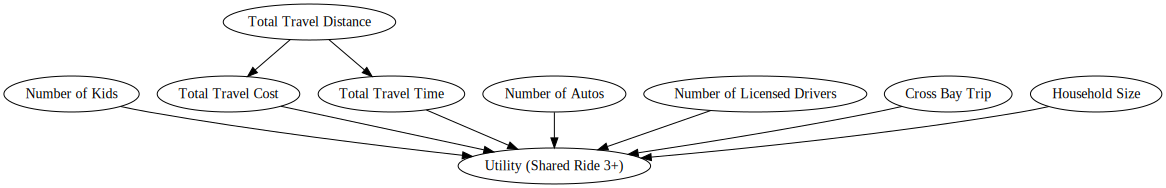

In [28]:
V_Shared_3p.draw()

In [29]:
Shared_3p_Df = bike_data_long[bike_data_long['mode_id']==3]
Shared_3p_Df.reset_index(drop=True,inplace=True)
Shared_3p_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_3p_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.4. Walk-Transit-Walk 

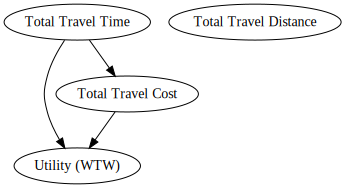

In [30]:
V_WTW.draw()

In [31]:
WTW_Df = bike_data_long[bike_data_long['mode_id']==4]
WTW_Df.reset_index(drop=True,inplace=True)
WTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.5. Drive-Transit-Walk 

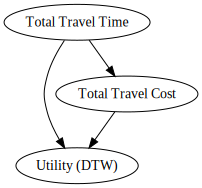

In [32]:
V_DTW.draw()

In [33]:
DTW_Df = bike_data_long[bike_data_long['mode_id']==5]
DTW_Df.reset_index(drop=True,inplace=True)
DTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = DTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.6. Walk-Transit-Drive 

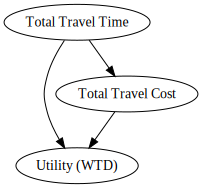

In [34]:
V_WTD.draw()

In [35]:
WTD_Df = bike_data_long[bike_data_long['mode_id']==6]
WTD_Df.reset_index(drop=True,inplace=True)
WTD_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTD_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.7. Walk

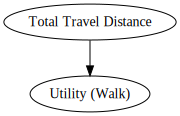

In [36]:
V_Walk.draw()

No regressions needed under the Walk alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

### 3.3.8. Bike

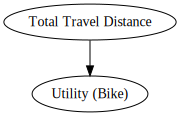

In [37]:
V_Bike.draw()

## 3.4. Simulate Nodes without Parents 

In [38]:
sim_size = 8000
sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)

## 3.5. Simulate data for each causal graph

In [39]:
# Create a copy of the data to avoid any issues
sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

### 3.5.1. Drive Alone 

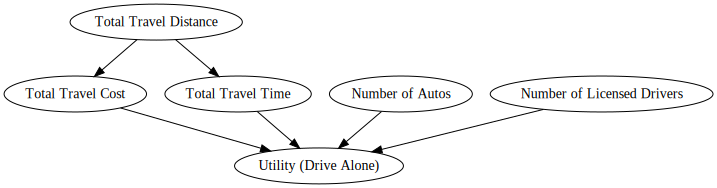

In [40]:
V_Drive_Alone.draw()

In [41]:
sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [42]:
# ## Loading data into StructuralCausalModel
# Drive_Alone_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_drive_alone'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "utility_drive_alone": lambda n_samples: np.zeros(shape=n_samples)
# })

# Drive_Alone_Model.sample(n_samples=4000).head()

### 3.5.2. Shared-2 

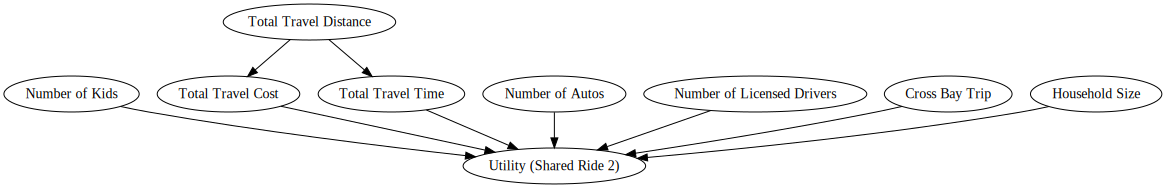

In [43]:
V_Shared_2.draw()

In [44]:
sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [45]:
# ## Loading data into StructuralCausalModel
# Shared_2_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_2'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_2": total_travel_cost: lambda n_samples: np.zeros(shape=bike_data_no_parent['total_travel_distance_shared_2'].shape[0])
# })
# Shared_2_Model.sample(n_samples=4000).head()

### 3.5.3. Shared-3+

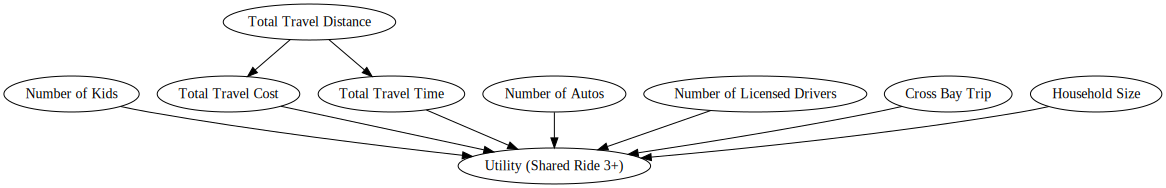

In [46]:
V_Shared_3p.draw()

In [47]:
sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [48]:
# ## Loading data into StructuralCausalModel
# Shared_3p_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_3p'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_3+": lambda n_samples: np.zeros(shape=n_samples)
# })

### 3.5.4. Walk-Transit-Walk

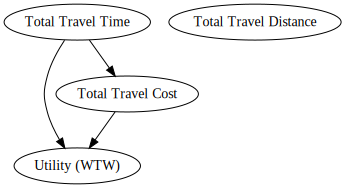

In [49]:
V_WTW.draw()

In [50]:
sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.5. Drive-Transit-Walk

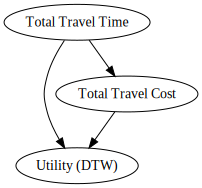

In [51]:
V_DTW.draw()

In [52]:
sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.6. Walk-Transit-Drive

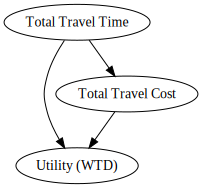

In [53]:
V_WTD.draw()

In [54]:
sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.7. Walk

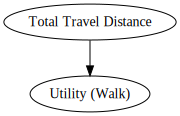

In [55]:
V_Walk.draw()

No need to simulate any other variables since Walk Total Travel Distance was already simulated

### 3.5.8. Bike

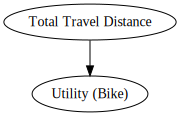

In [56]:
V_Bike.draw()

No need to simulate any other variables since Bike Total Travel Distance was already simulated

## 3.6. Simulate Availability of Alternatives 

In [57]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices
wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                     sim_data=sim_bike_data_wide,
                                     obs_id_col=observation_id_col,
                                     alt_name_dict=alternative_name_dict)

## 3.7. Convert Simulated Data from Wide to Long

In [58]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']



# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                            }


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "observation_id"
wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                         dtype=int) + 1


# Declare choice column
choice_column = "sim_choice"

In [59]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

In [60]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

In [61]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

## 3.8. Simulate Choices 

In [62]:
# Calculate probabilities for each alternative
# based on the estimated model
posterior_probs = mnl_model.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [63]:
# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)

## 3.9. Estimate Model

In [64]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -15,169.1932
Initial Log-likelihood: -15,169.1932


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -5,568.2677


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,981
Method:                                MLE   Df Model:                           19
Date:                     Sat, 28 Mar 2020   Pseudo R-squ.:                   0.633
Time:                             12:36:17   Pseudo R-bar-squ.:               0.632
AIC:                            11,174.535   Log-Likelihood:             -5,568.268
BIC:                            11,307.292   LL-Null:                   -15,169.193
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0427      0.129     -8.080      0.000      -1.296      -0.790
ASC Shared Ride: 3+                                      3.6770      0.202     18.187      0.000       3.281       4.073
ASC Walk-Transit-Walk                                   -0.4810      0.143     -3.367      0.001      -0.761      -0.201
ASC Drive-Transit-Walk                                  -2.5540      0.148    -17.293      0.000      -2.843      -2.265
ASC Walk-Transit-Drive                                  -3.1982      0.162    -19.700      0.000      -3.516      -2.880
ASC Walk                                                 1.5064      0.145     10.416      0.000       1.223       1.790
ASC Bike                                                -1.3175      0.116    -11.351      0.000      -1.545      -1.090
Travel Time, units:min (All Auto Modes)                 -0.0769      0.002    -33.205      0.000      -0.081      -0.072
Travel Time, units:min (All Transit Modes)              -0.0290      0.002    -19.203      0.000      -0.032      -0.026
Travel Cost, units:$ (All Transit Modes)                -0.1251      0.019     -6.438      0.000      -0.163      -0.087
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.1524      0.190    -27.172      0.000      -5.524      -4.781
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.4075      0.642    -31.810      0.000     -21.665     -19.150
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -96.3368      2.806    -34.330      0.000    -101.837     -90.837
Autos per licensed drivers (All Auto Modes)              1.1744      0.060     19.517      0.000       1.056       1.292
Travel Distance, units:mi (Walk)                        -1.0597      0.037    -28.305      0.000      -1.133      -0.986
Travel Distance, units:mi (Bike)                        -0.2801      0.015    -18.667      0.000      -0.309      -0.251
Cross-Bay Tour (Shared Ride 2 & 3+)                      1.2513      0.156      8.033      0.000       0.946       1.557
Household Size (Shared Ride 2 & 3+)                      0.1259      0.029      4.410      0.000       0.070       0.182
Number of Kids in Household (Shared Ride 2 & 3+)         0.6400      0.034     18.726      0.000       0.573       0.707
========================================================================================================================
"""

# 4. Simulate and Estimate N Times

In [65]:
simulation_sizes = np.random.randint(low=3000, high=9000, size=100)
sim_number = np.arange(1,101)
models_dictionary = defaultdict(dict)

for sim_size, number in zip(simulation_sizes, sim_number):
    print('Simulation number', number , 'is in progress...')
    print ('Simulation size is', sim_size)
    print('------------------------------------------')
    print('Simulating data...')
    # Simulate data without parents
    sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)
    
    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    # Drive Alone
    sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    
    # Shared Ride 2
    sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    # Shared Ride 3+
    sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                      Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    # Walk-Transit-Walk
    sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size=sim_size)
    # Drive-Transit-Walk
    sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    # Walk-Transit-Drive
    sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    
    #Simulate Availability
    print('Simulating Availability...')
    wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                         sim_data=sim_bike_data_wide,
                                         obs_id_col=observation_id_col,
                                         alt_name_dict=alternative_name_dict)

    wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                            dtype=int) + 1
    
    print('Converting data from wide to long...')
    long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)
    
    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                        "total_travel_distance"])
    print('Simulating Choices...')
    # Calculate probabilities for each alternative
    # based on the estimated model
    posterior_probs = mnl_model.predict(long_sim_data)
    
    
    # Simulate choice data
    long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)
    
    
    print('Estimating the choice model...')
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

    num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
    # Note newton-cg used to ensure convergence to a point where gradient 
    # is essentially zero for all dimensions. 
    mnl_model_sim.fit_mle(np.zeros(num_vars),
                          method="BFGS")
    
    mnl_model_sim.coefs.name = 'simulation_' + str(number)

    models_dictionary[number] = mnl_model_sim
    
    print('Simulation number', number , 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in progress...
Simulation size is 6955
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,168.4640
Initial Log-likelihood: -13,168.4640


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.55 seconds.
Final log-likelihood: -4,753.0002
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 4956
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,404.4889
Initial Log-likelihood: -9,404.4889


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,427.3302
Simulation number 2 is complete!
Simulation number 3 is in progress...
Simulation size is 8871
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,840.2147
Initial Log-likelihood: -16,840.2147


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -6,192.5281
Simulation number 3 is complete!
Simulation number 4 is in progress...
Simulation size is 4191
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,972.0177
Initial Log-likelihood: -7,972.0177


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -2,965.3781
Simulation number 4 is complete!
Simulation number 5 is in progress...
Simulation size is 5999
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,405.6666
Initial Log-likelihood: -11,405.6666


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -4,276.7086
Simulation number 5 is complete!
Simulation number 6 is in progress...
Simulation size is 3613
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,861.6563
Initial Log-likelihood: -6,861.6563
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,600.0264


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 6 is complete!
Simulation number 7 is in progress...
Simulation size is 6341
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,048.0240
Initial Log-likelihood: -12,048.0240


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -4,566.3332
Simulation number 7 is complete!
Simulation number 8 is in progress...
Simulation size is 5821
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,057.4665
Initial Log-likelihood: -11,057.4665


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,047.8350
Simulation number 8 is complete!
Simulation number 9 is in progress...
Simulation size is 3753
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,126.9753
Initial Log-likelihood: -7,126.9753
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,689.6929


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 9 is complete!
Simulation number 10 is in progress...
Simulation size is 7180
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,639.5995
Initial Log-likelihood: -13,639.5995


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -5,135.1636
Simulation number 10 is complete!
Simulation number 11 is in progress...
Simulation size is 6364
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,077.4932
Initial Log-likelihood: -12,077.4932


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.47 seconds.
Final log-likelihood: -4,488.0017
Simulation number 11 is complete!
Simulation number 12 is in progress...
Simulation size is 5044
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,565.5125
Initial Log-likelihood: -9,565.5125


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -3,543.1931
Simulation number 12 is complete!
Simulation number 13 is in progress...
Simulation size is 4944
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,362.1544
Initial Log-likelihood: -9,362.1544


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.29 seconds.
Final log-likelihood: -3,591.3814
Simulation number 13 is complete!
Simulation number 14 is in progress...
Simulation size is 7948
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,106.0171
Initial Log-likelihood: -15,106.0171


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.58 seconds.
Final log-likelihood: -5,656.3406
Simulation number 14 is complete!
Simulation number 15 is in progress...
Simulation size is 5515
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,498.0673
Initial Log-likelihood: -10,498.0673


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,975.7774
Simulation number 15 is complete!
Simulation number 16 is in progress...
Simulation size is 8397
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,945.5722
Initial Log-likelihood: -15,945.5722


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,926.4497
Simulation number 16 is complete!
Simulation number 17 is in progress...
Simulation size is 5637
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,708.2757
Initial Log-likelihood: -10,708.2757


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -4,072.8354
Simulation number 17 is complete!
Simulation number 18 is in progress...
Simulation size is 5019
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,524.0176
Initial Log-likelihood: -9,524.0176


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,577.0552
Simulation number 18 is complete!
Simulation number 19 is in progress...
Simulation size is 5706
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,802.0129
Initial Log-likelihood: -10,802.0129


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -4,023.3421
Simulation number 19 is complete!
Simulation number 20 is in progress...
Simulation size is 8482
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,097.8285
Initial Log-likelihood: -16,097.8285


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -5,944.8421
Simulation number 20 is complete!
Simulation number 21 is in progress...
Simulation size is 4900
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,272.1240
Initial Log-likelihood: -9,272.1240


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,283.7914
Simulation number 21 is complete!
Simulation number 22 is in progress...
Simulation size is 4293
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,122.7535
Initial Log-likelihood: -8,122.7535


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -2,961.3726
Simulation number 22 is complete!
Simulation number 23 is in progress...
Simulation size is 7379
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,999.8353
Initial Log-likelihood: -13,999.8353


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -5,256.7640
Simulation number 23 is complete!
Simulation number 24 is in progress...
Simulation size is 8217
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,605.4436
Initial Log-likelihood: -15,605.4436


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,602.7599
Simulation number 24 is complete!
Simulation number 25 is in progress...
Simulation size is 4926
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,368.7634
Initial Log-likelihood: -9,368.7634


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -3,531.2808
Simulation number 25 is complete!
Simulation number 26 is in progress...
Simulation size is 3997
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,588.9335
Initial Log-likelihood: -7,588.9335


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,797.8383
Simulation number 26 is complete!
Simulation number 27 is in progress...
Simulation size is 5989
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,346.4963
Initial Log-likelihood: -11,346.4963


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,233.9722
Simulation number 27 is complete!
Simulation number 28 is in progress...
Simulation size is 7772
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,709.0879
Initial Log-likelihood: -14,709.0879


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,557.1723
Simulation number 28 is complete!
Simulation number 29 is in progress...
Simulation size is 5421
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,300.8051
Initial Log-likelihood: -10,300.8051


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -3,884.6328
Simulation number 29 is complete!
Simulation number 30 is in progress...
Simulation size is 5028
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,526.0427
Initial Log-likelihood: -9,526.0427


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,453.3466
Simulation number 30 is complete!
Simulation number 31 is in progress...
Simulation size is 3659
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,947.3699
Initial Log-likelihood: -6,947.3699
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,629.0820


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 31 is complete!
Simulation number 32 is in progress...
Simulation size is 6614
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,547.4698
Initial Log-likelihood: -12,547.4698


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.68 seconds.
Final log-likelihood: -4,677.1267
Simulation number 32 is complete!
Simulation number 33 is in progress...
Simulation size is 4905
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,312.1686
Initial Log-likelihood: -9,312.1686


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,418.5772
Simulation number 33 is complete!
Simulation number 34 is in progress...
Simulation size is 5708
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,845.8585
Initial Log-likelihood: -10,845.8585


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,047.6296
Simulation number 34 is complete!
Simulation number 35 is in progress...
Simulation size is 6675
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,701.8072
Initial Log-likelihood: -12,701.8072


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,767.8146
Simulation number 35 is complete!
Simulation number 36 is in progress...
Simulation size is 8465
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,048.7183
Initial Log-likelihood: -16,048.7183


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.53 seconds.
Final log-likelihood: -5,954.0642
Simulation number 36 is complete!
Simulation number 37 is in progress...
Simulation size is 5944
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,280.8921
Initial Log-likelihood: -11,280.8921


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.48 seconds.
Final log-likelihood: -4,183.5267
Simulation number 37 is complete!
Simulation number 38 is in progress...
Simulation size is 3988
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,558.2231
Initial Log-likelihood: -7,558.2231
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,770.4165


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 38 is complete!
Simulation number 39 is in progress...
Simulation size is 6899
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,094.7544
Initial Log-likelihood: -13,094.7544


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,999.5241
Simulation number 39 is complete!
Simulation number 40 is in progress...
Simulation size is 4063
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,723.6520
Initial Log-likelihood: -7,723.6520
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,751.5172


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 40 is complete!
Simulation number 41 is in progress...
Simulation size is 6884
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,061.1460
Initial Log-likelihood: -13,061.1460


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -4,840.2203
Simulation number 41 is complete!
Simulation number 42 is in progress...
Simulation size is 8830
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,793.1460
Initial Log-likelihood: -16,793.1460


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.82 seconds.
Final log-likelihood: -6,275.9924
Simulation number 42 is complete!
Simulation number 43 is in progress...
Simulation size is 7131
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,568.0357
Initial Log-likelihood: -13,568.0357


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -5,109.4431
Simulation number 43 is complete!
Simulation number 44 is in progress...
Simulation size is 7590
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,383.9472
Initial Log-likelihood: -14,383.9472


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,213.4565
Simulation number 44 is complete!
Simulation number 45 is in progress...
Simulation size is 8989
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -17,042.1547
Initial Log-likelihood: -17,042.1547


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -6,346.0110
Simulation number 45 is complete!
Simulation number 46 is in progress...
Simulation size is 8225
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,606.9338
Initial Log-likelihood: -15,606.9338


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.71 seconds.
Final log-likelihood: -5,598.6964
Simulation number 46 is complete!
Simulation number 47 is in progress...
Simulation size is 7686
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,560.9722
Initial Log-likelihood: -14,560.9722


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.44 seconds.
Final log-likelihood: -5,392.4419
Simulation number 47 is complete!
Simulation number 48 is in progress...
Simulation size is 4500
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,551.3260
Initial Log-likelihood: -8,551.3260


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,264.8226
Simulation number 48 is complete!
Simulation number 49 is in progress...
Simulation size is 5492
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,439.9704
Initial Log-likelihood: -10,439.9704


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.29 seconds.
Final log-likelihood: -3,824.1003
Simulation number 49 is complete!
Simulation number 50 is in progress...
Simulation size is 5822
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,048.7103
Initial Log-likelihood: -11,048.7103


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -3,990.1377
Simulation number 50 is complete!
Simulation number 51 is in progress...
Simulation size is 7411
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,068.1195
Initial Log-likelihood: -14,068.1195


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -5,200.6680
Simulation number 51 is complete!
Simulation number 52 is in progress...
Simulation size is 3251
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,171.5495
Initial Log-likelihood: -6,171.5495
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,268.1227


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 52 is complete!
Simulation number 53 is in progress...
Simulation size is 6460
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,254.9162
Initial Log-likelihood: -12,254.9162


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,476.5867
Simulation number 53 is complete!
Simulation number 54 is in progress...
Simulation size is 8713
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,538.3528
Initial Log-likelihood: -16,538.3528


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.49 seconds.
Final log-likelihood: -6,146.0879
Simulation number 54 is complete!
Simulation number 55 is in progress...
Simulation size is 3441
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,533.4079
Initial Log-likelihood: -6,533.4079
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,411.7567


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 55 is complete!
Simulation number 56 is in progress...
Simulation size is 4964
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,434.1993
Initial Log-likelihood: -9,434.1993


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -3,527.9768
Simulation number 56 is complete!
Simulation number 57 is in progress...
Simulation size is 3705
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,026.9071
Initial Log-likelihood: -7,026.9071
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,550.4118


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 57 is complete!
Simulation number 58 is in progress...
Simulation size is 3543
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,725.8038
Initial Log-likelihood: -6,725.8038
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -2,468.9702


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 58 is complete!
Simulation number 59 is in progress...
Simulation size is 3139
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -5,964.8410
Initial Log-likelihood: -5,964.8410
Estimation Time for Point Estimation: 0.16 seconds.
Final log-likelihood: -2,236.2704


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 59 is complete!
Simulation number 60 is in progress...
Simulation size is 4531
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,595.7971
Initial Log-likelihood: -8,595.7971


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,166.6114
Simulation number 60 is complete!
Simulation number 61 is in progress...
Simulation size is 6976
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,245.0270
Initial Log-likelihood: -13,245.0270


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.40 seconds.
Final log-likelihood: -4,819.6459
Simulation number 61 is complete!
Simulation number 62 is in progress...
Simulation size is 3361
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,373.9760
Initial Log-likelihood: -6,373.9760
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -2,368.2833


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 62 is complete!
Simulation number 63 is in progress...
Simulation size is 7589
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,418.7346
Initial Log-likelihood: -14,418.7346


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -5,508.8802
Simulation number 63 is complete!
Simulation number 64 is in progress...
Simulation size is 7337
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,897.6057
Initial Log-likelihood: -13,897.6057


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.59 seconds.
Final log-likelihood: -5,160.8479
Simulation number 64 is complete!
Simulation number 65 is in progress...
Simulation size is 6747
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,797.8864
Initial Log-likelihood: -12,797.8864


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.41 seconds.
Final log-likelihood: -4,699.5308
Simulation number 65 is complete!
Simulation number 66 is in progress...
Simulation size is 5036
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,560.6657
Initial Log-likelihood: -9,560.6657


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,511.2064
Simulation number 66 is complete!
Simulation number 67 is in progress...
Simulation size is 4723
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,966.6974
Initial Log-likelihood: -8,966.6974


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -3,314.1774
Simulation number 67 is complete!
Simulation number 68 is in progress...
Simulation size is 8343
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,848.6245
Initial Log-likelihood: -15,848.6245


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.46 seconds.
Final log-likelihood: -5,843.9925
Simulation number 68 is complete!
Simulation number 69 is in progress...
Simulation size is 4989
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,459.5535
Initial Log-likelihood: -9,459.5535


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -3,550.0492
Simulation number 69 is complete!
Simulation number 70 is in progress...
Simulation size is 7860
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,929.7907
Initial Log-likelihood: -14,929.7907


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -5,539.8423
Simulation number 70 is complete!
Simulation number 71 is in progress...
Simulation size is 7697
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,591.4002
Initial Log-likelihood: -14,591.4002


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,466.0816
Simulation number 71 is complete!
Simulation number 72 is in progress...
Simulation size is 8176
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,534.0237
Initial Log-likelihood: -15,534.0237


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -5,672.1080
Simulation number 72 is complete!
Simulation number 73 is in progress...
Simulation size is 5072
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,599.0509
Initial Log-likelihood: -9,599.0509


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -3,640.5373
Simulation number 73 is complete!
Simulation number 74 is in progress...
Simulation size is 5609
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,636.0533
Initial Log-likelihood: -10,636.0533


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.30 seconds.
Final log-likelihood: -4,080.3930
Simulation number 74 is complete!
Simulation number 75 is in progress...
Simulation size is 5003
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,503.3385
Initial Log-likelihood: -9,503.3385


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,489.4449
Simulation number 75 is complete!
Simulation number 76 is in progress...
Simulation size is 4795
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,083.1189
Initial Log-likelihood: -9,083.1189


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -3,250.6149
Simulation number 76 is complete!
Simulation number 77 is in progress...
Simulation size is 8595
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,326.1384
Initial Log-likelihood: -16,326.1384


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -6,129.8163
Simulation number 77 is complete!
Simulation number 78 is in progress...
Simulation size is 6049
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -11,490.8533
Initial Log-likelihood: -11,490.8533


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.35 seconds.
Final log-likelihood: -4,218.8055
Simulation number 78 is complete!
Simulation number 79 is in progress...
Simulation size is 7699
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -14,615.4301
Initial Log-likelihood: -14,615.4301


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,438.9706
Simulation number 79 is complete!
Simulation number 80 is in progress...
Simulation size is 4607
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,773.1567
Initial Log-likelihood: -8,773.1567


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -3,239.7997
Simulation number 80 is complete!
Simulation number 81 is in progress...
Simulation size is 7166
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,613.8674
Initial Log-likelihood: -13,613.8674


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.65 seconds.
Final log-likelihood: -5,052.3428
Simulation number 81 is complete!
Simulation number 82 is in progress...
Simulation size is 3057
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -5,794.3582
Initial Log-likelihood: -5,794.3582
Estimation Time for Point Estimation: 0.15 seconds.
Final log-likelihood: -2,137.6955


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 82 is complete!
Simulation number 83 is in progress...
Simulation size is 3184
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,041.6740
Initial Log-likelihood: -6,041.6740
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,180.3373


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 83 is complete!
Simulation number 84 is in progress...
Simulation size is 6654
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -12,605.5073
Initial Log-likelihood: -12,605.5073


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -4,651.3809
Simulation number 84 is complete!
Simulation number 85 is in progress...
Simulation size is 8479
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -16,090.8034
Initial Log-likelihood: -16,090.8034


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -6,172.8324
Simulation number 85 is complete!
Simulation number 86 is in progress...
Simulation size is 3040
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -5,775.3438
Initial Log-likelihood: -5,775.3438
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,166.8452


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 86 is complete!
Simulation number 87 is in progress...
Simulation size is 4505
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -8,547.2955
Initial Log-likelihood: -8,547.2955


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -3,202.9100
Simulation number 87 is complete!
Simulation number 88 is in progress...
Simulation size is 5699
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,809.5361
Initial Log-likelihood: -10,809.5361


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -3,925.8091
Simulation number 88 is complete!
Simulation number 89 is in progress...
Simulation size is 4163
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,895.6211
Initial Log-likelihood: -7,895.6211


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.21 seconds.
Final log-likelihood: -3,039.1579
Simulation number 89 is complete!
Simulation number 90 is in progress...
Simulation size is 8141
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -15,452.5757
Initial Log-likelihood: -15,452.5757


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.42 seconds.
Final log-likelihood: -5,806.4731
Simulation number 90 is complete!
Simulation number 91 is in progress...
Simulation size is 5758
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,932.6647
Initial Log-likelihood: -10,932.6647


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.27 seconds.
Final log-likelihood: -4,130.6026
Simulation number 91 is complete!
Simulation number 92 is in progress...
Simulation size is 5140
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,756.2516
Initial Log-likelihood: -9,756.2516


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,571.7948
Simulation number 92 is complete!
Simulation number 93 is in progress...
Simulation size is 7267
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,803.5449
Initial Log-likelihood: -13,803.5449


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.36 seconds.
Final log-likelihood: -5,095.9808
Simulation number 93 is complete!
Simulation number 94 is in progress...
Simulation size is 4043
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,668.1725
Initial Log-likelihood: -7,668.1725


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -2,846.0677
Simulation number 94 is complete!
Simulation number 95 is in progress...
Simulation size is 5627
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -10,687.3140
Initial Log-likelihood: -10,687.3140


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.43 seconds.
Final log-likelihood: -3,955.9579
Simulation number 95 is complete!
Simulation number 96 is in progress...
Simulation size is 5086
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -9,675.4081
Initial Log-likelihood: -9,675.4081


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -3,596.7127
Simulation number 96 is complete!
Simulation number 97 is in progress...
Simulation size is 4184
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -7,941.9757
Initial Log-likelihood: -7,941.9757


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.32 seconds.
Final log-likelihood: -2,957.8350
Simulation number 97 is complete!
Simulation number 98 is in progress...
Simulation size is 3177
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,030.6681
Initial Log-likelihood: -6,030.6681
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -2,192.8236


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 98 is complete!
Simulation number 99 is in progress...
Simulation size is 7243
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -13,745.5022
Initial Log-likelihood: -13,745.5022


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.39 seconds.
Final log-likelihood: -5,116.0796
Simulation number 99 is complete!
Simulation number 100 is in progress...
Simulation size is 3293
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...
Log-likelihood at zero: -6,237.4243
Initial Log-likelihood: -6,237.4243
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -2,255.5674


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Simulation number 100 is complete!


# 5. Plotting results of the simulation 

In [69]:
# Creating a dataframe for model parameters
sim_estimated_par = pd.concat([models_dictionary[number].coefs for number in models_dictionary.keys()], axis=1).T
sim_estimated_par.reset_index(drop=True,inplace=True)
sim_estimated_par.head()

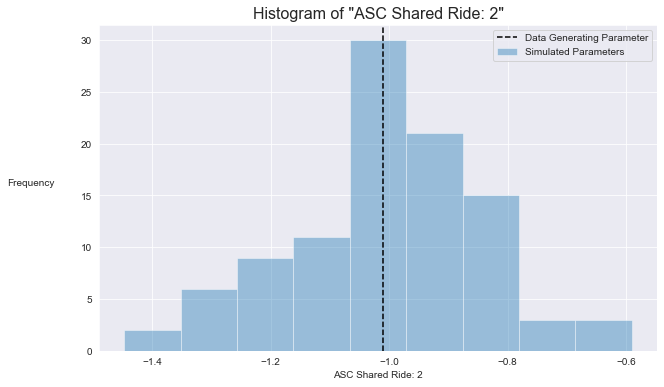

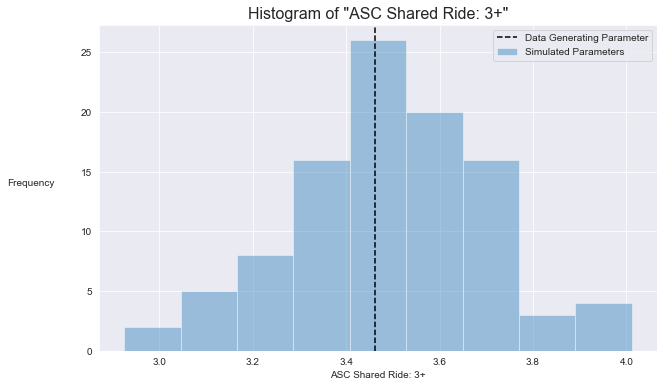

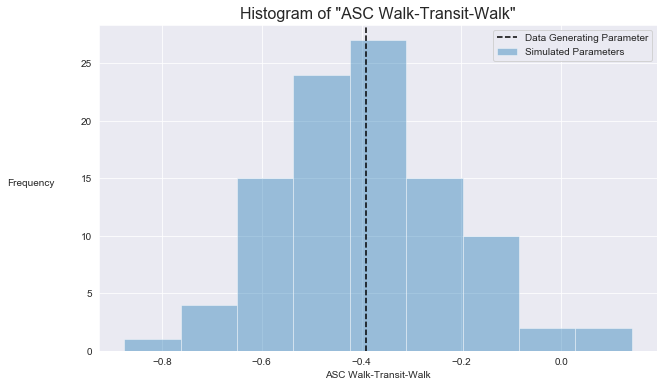

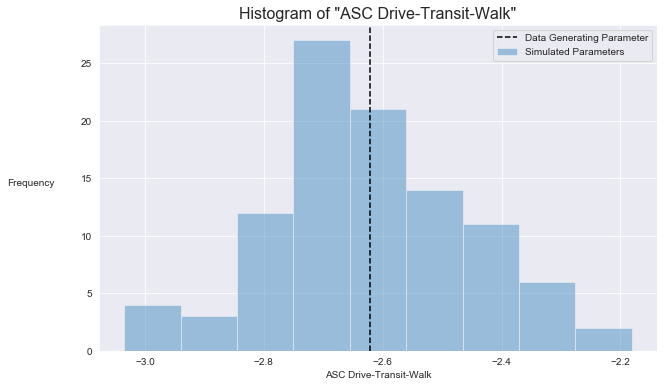

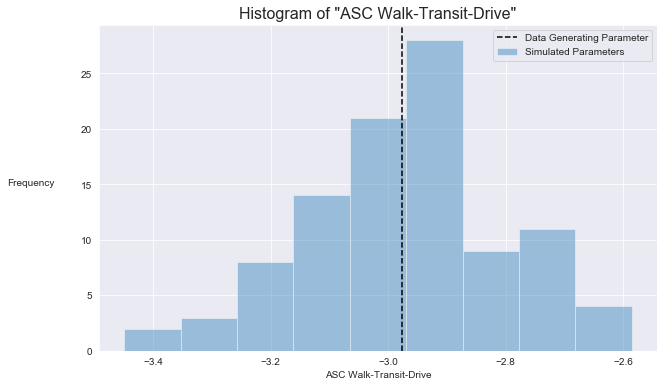

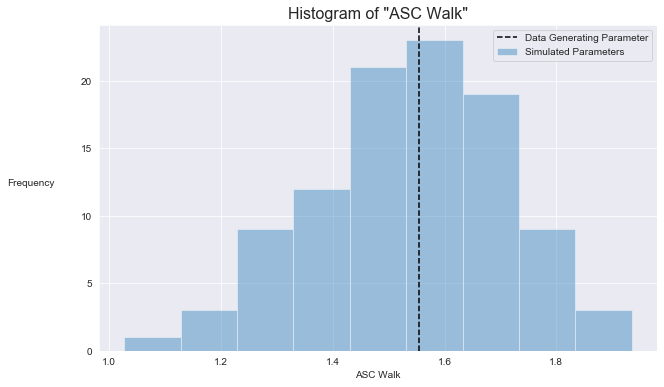

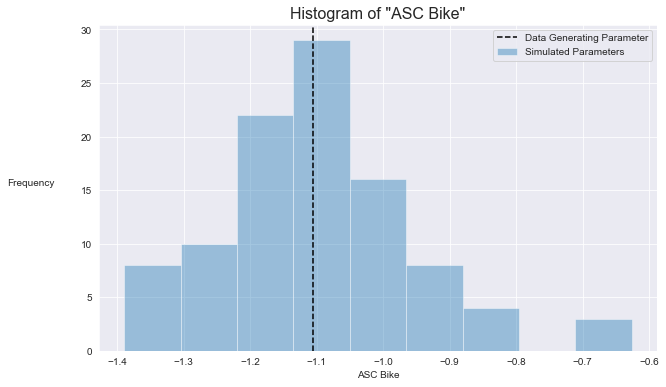

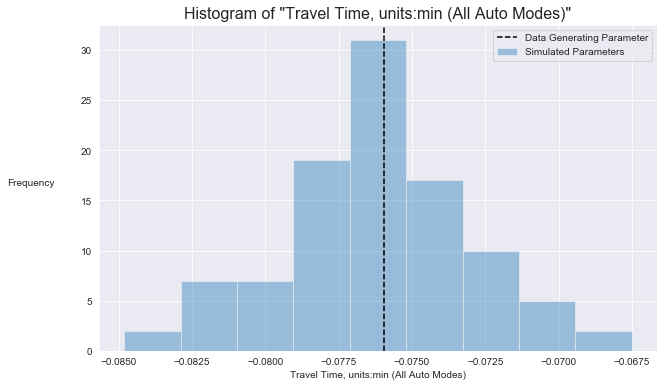

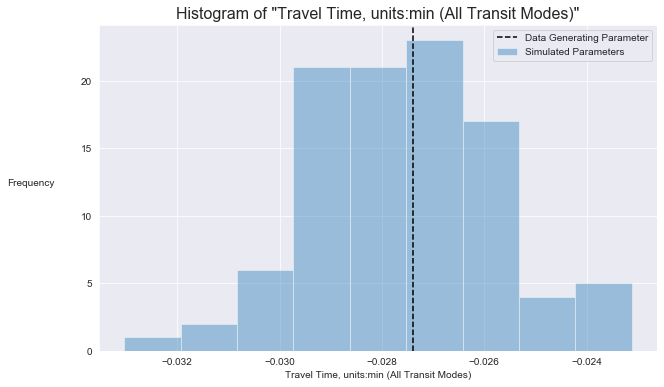

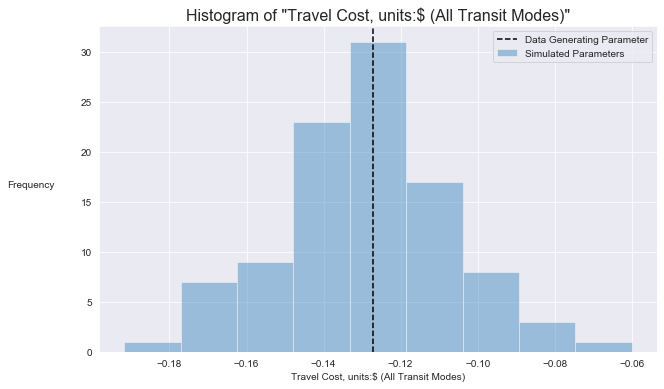

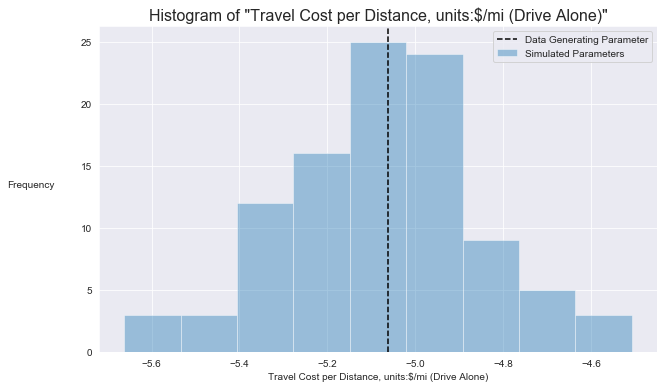

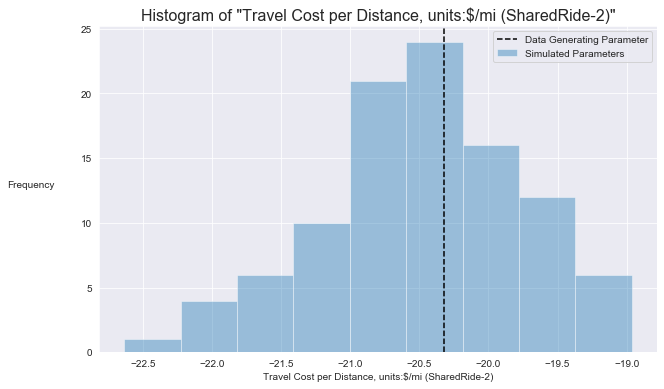

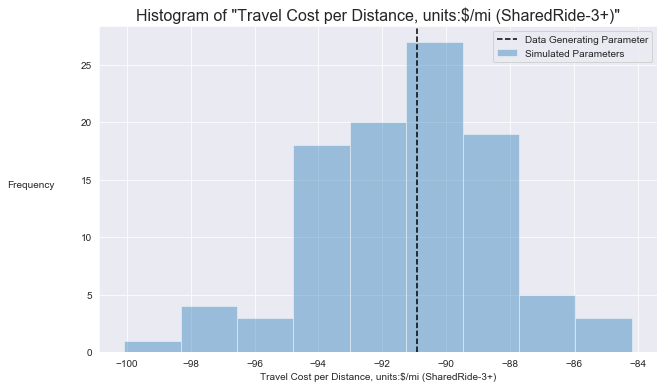

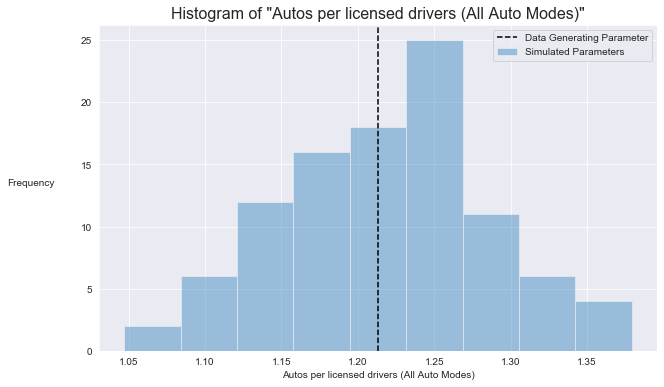

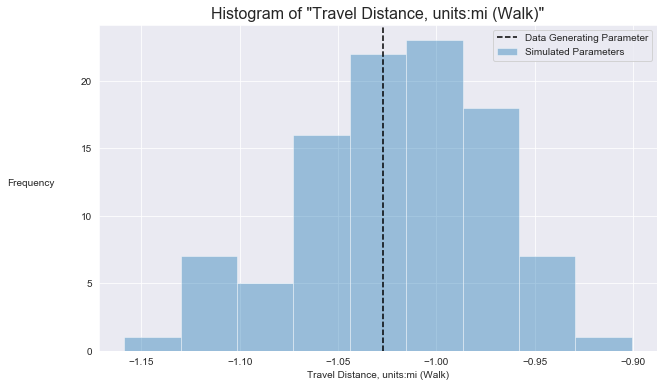

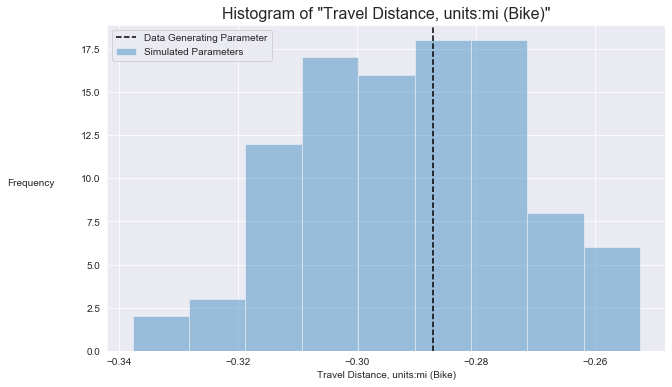

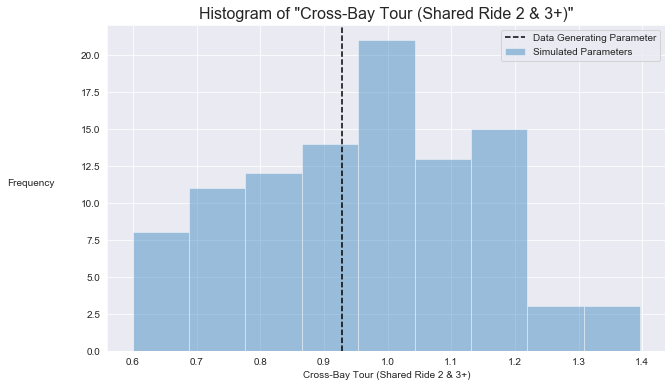

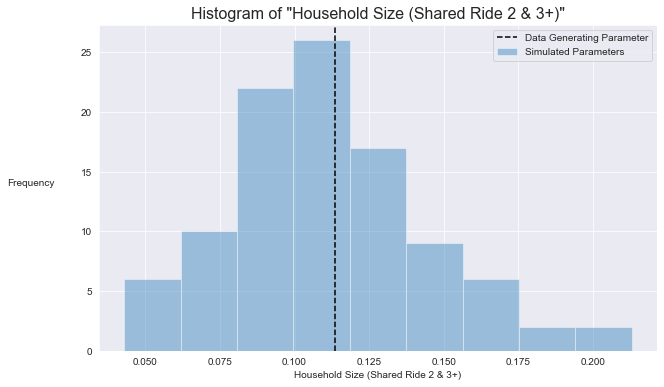

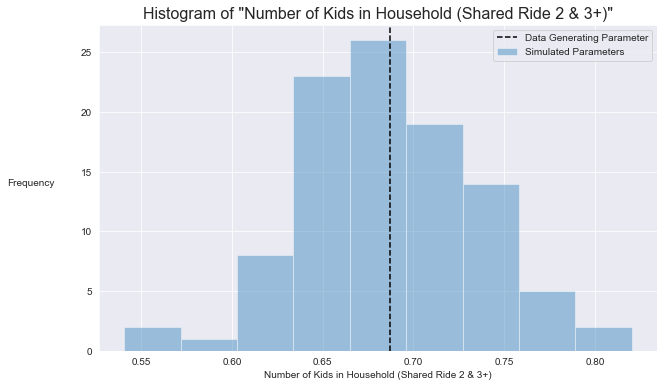

In [77]:
# Loop around the different parameters
# and plot the figures:

for par in sim_estimated_par.columns:
    PlotParams(sim_estimated_par[par],mnl_model, (10,6))